# Sentiment Analysis

## Load the Data

### Import

In [79]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

### Merging Datasets

Combine all reviews into one file

In [80]:
file_paths = ['./data/archive/reviews_0-250.csv',
              './data/archive/reviews_250-500.csv',
              './data/archive/reviews_500-750.csv',
              './data/archive/reviews_750-1250.csv',
              './data/archive/reviews_1250-end.csv']

dataframes = [pd.read_csv(file) for file in file_paths]

/var/folders/16/59f4vdfs1j10515946gfx2mm0000gn/T/ipykernel_10697/1848543797.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in file_paths]
/var/folders/16/59f4vdfs1j10515946gfx2mm0000gn/T/ipykernel_10697/1848543797.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in file_paths]
/var/folders/16/59f4vdfs1j10515946gfx2mm0000gn/T/ipykernel_10697/1848543797.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in file_paths]


Concatenate all DataFrames

In [81]:
df = pd.concat(dataframes, ignore_index=True)

In [82]:
df.head()

,review_id,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [83]:
df.shape

(1094411, 19)

Now we have over 1 million reviews together

## EDA

### Brief look into features

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094411 entries, 0 to 1094410
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   review_id                 1094411 non-null  int64  
 1   author_id                 1094411 non-null  object 
 2   rating                    1094411 non-null  int64  
 3   is_recommended            926423 non-null   float64
 4   helpfulness               532819 non-null   float64
 5   total_feedback_count      1094411 non-null  int64  
 6   total_neg_feedback_count  1094411 non-null  int64  
 7   total_pos_feedback_count  1094411 non-null  int64  
 8   submission_time           1094411 non-null  object 
 9   review_text               1092967 non-null  object 
 10  review_title              783757 non-null   object 
 11  skin_tone                 923872 non-null   object 
 12  eye_color                 884783 non-null   object 
 13  skin_type                 9

Determining the __essential__, __possible enhancement__ and __further analysis__ features

In [85]:
essential_features = ['review_id',
                      'review_text',        # most critical, body of text
                      'product_id']         # will be important for the whole recommendation system

enhancing_features = ['rating',             # might help
                      'review_title',       # can also be analyzed
                      'is_recommended',
                      'author_id']     # can be used to quickly analyze sentiment ***
                          

further_features = ['submission_time',              # sentiment change over time
                    'helpfulness',
                    'total_feedback_count',
                    'total_neg_feedback_count',     # can give context to weight and reception of review
                    'skin_tone',
                    'eye_color',
                    'skin_type',
                    'hair_color',                   # if we use personalization later
                    'brand_name',
                    'price_usd']                    # sentiment across brands or price ranges

### Prepare essential DataFrame

In [86]:
df_essential = df[essential_features + enhancing_features]

In [87]:
df_essential.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835


Drop rows with missing reviews

In [88]:
df_essential = df_essential.dropna(subset=['review_text'])

In [89]:
df_essential.shape

(1092967, 7)

### Clean special characters from reviews

In [90]:
# Regex approach to remove any special characters other than alphabet, numbers and whitespace
# but we might need basic smiley emoticons like :), :(, etc.

#df_essential['review_text'] = df_essential['review_text'].str.lower().replace('[^a-z0-9\s]', '', regex=True)

Here is hopefully a better approach to remove unwanted characters while keeping the emoticons which actually contribute to the sentiment analysis. For example:

Without proper handling following reviews might be treated wrongly

`"I love this product:)"`

`":)great product"`

In those cases they might get split into words and we might end up with words like 

`"product:)"`
and
`":)great"`

Or even the combined cases such as:

`"I love this product:)great"`

will be separated into first:

`"I love this product :)great"`

and then 

`"I love this product :) great"`

The following function aims to make sure emoticons are separated from the words:

In [91]:
# Function to clean text and preserve emoticons
def clean_text(text):
    emoticons = r"(:\)|:\(|;\)|:D|:P)"

    # Separate emoticons from text
    # Ensure space between words and emoticons
    clean_txt = re.sub(r'([a-z0-9])([:;][()DP])', r'\1 \2', text.lower())
    # Ensure space between emoticons and words
    clean_txt = re.sub(r'([:;][()DP])([a-z0-9])', r'\1 \2', clean_txt)
    
    # Retain letters, numbers, spaces, basic emoticons, and certain punctuation marks
    clean_txt = re.sub(r'[^a-z0-9\s:;()DP!?\'\.,’]', '', clean_txt)
    
    return clean_txt

Applying the function to the DataFrame

In [92]:
df_essential['cleaned_review_text'] = df_essential['review_text'].apply(clean_text)

In [93]:
df_essential[['review_text', 'cleaned_review_text']].head(10)

,review_text,cleaned_review_text
0,I use this with the Nudestix “Citrus Clean Bal...,i use this with the nudestix citrus clean balm...
1,I bought this lip mask after reading the revie...,i bought this lip mask after reading the revie...
2,My review title says it all! I get so excited ...,my review title says it all! i get so excited ...
3,I’ve always loved this formula for a long time...,i’ve always loved this formula for a long time...
4,"If you have dry cracked lips, this is a must h...","if you have dry cracked lips, this is a must h..."
5,The scent isn’t my favourite but it works grea...,the scent isn’t my favourite but it works grea...
6,I’ll give this 2 stars for nice packaging and ...,i’ll give this 2 stars for nice packaging and ...
7,I use this at night or while I’m putting makeu...,i use this at night or while i’m putting makeu...
8,I love this stuff. I first had the sample size...,i love this stuff. i first had the sample size...
9,I purchased the Sweet Candy scent at my local ...,i purchased the sweet candy scent at my local ...


Check for empty reviews after cleaning

In [94]:
empty_reviews = df_essential['cleaned_review_text'].str.strip().replace('', pd.NA)
df_essential['cleaned_review_text'] = empty_reviews # update column with stripped strings/empty values

empty_count = df_essential['cleaned_review_text'].isna().sum()
print(f"Number of empty reviews after cleaning: {empty_count}")

Number of empty reviews after cleaning: 5


Remove these from the DataFrame

In [95]:
original_size = df_essential.shape[0]
df_essential = df_essential.dropna(subset=['cleaned_review_text'])
new_size = df_essential.shape[0]

print(f"Removed {original_size - new_size} rows with empty reviews.")

Removed 5 rows with empty reviews.


### Check for duplicates

Here the approach is to remove duplicate:

- Same product_id 
- Same author_id
- Same review_text      -> Remove

In [96]:
df_essential.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092962 entries, 0 to 1094410
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   review_id            1092962 non-null  int64  
 1   review_text          1092962 non-null  object 
 2   product_id           1092962 non-null  object 
 3   rating               1092962 non-null  int64  
 4   review_title         783754 non-null   object 
 5   is_recommended       924974 non-null   float64
 6   author_id            1092962 non-null  object 
 7   cleaned_review_text  1092962 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 75.0+ MB


In [97]:
# Remove duplicate reviews from the same person
df_essential = df_essential.drop_duplicates(subset=['author_id', 'product_id', 'review_text'])
print("Data size after removing true duplicates:", df_essential.shape)

Data size after removing true duplicates: (1092406, 8)


### Brief summary so far

1. Checked the datasets and merged the reviews into one DataFrame
2. Categorized the features
3. Cleaned special characters (like #)
4. Removed duplicate reviews from the same person for the same product 


### Basic Visualizations & NLTK Tests

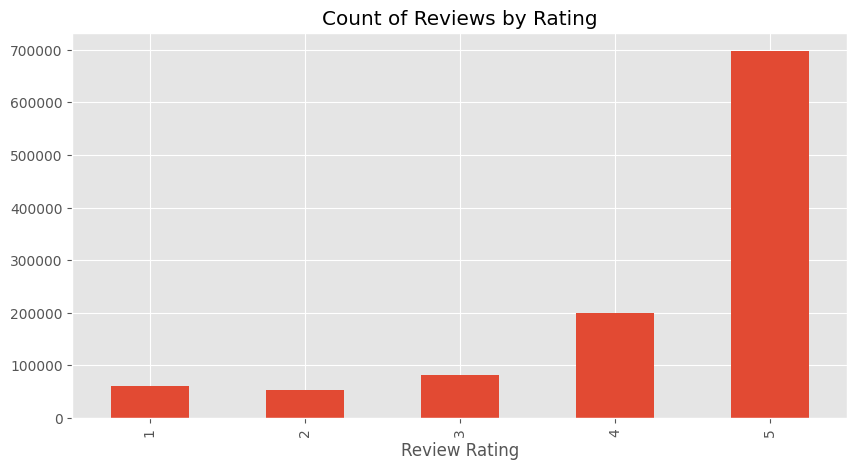

In [98]:
ax = df_essential['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Rating',
          figsize=(10, 5))
ax.set_xlabel('Review Rating')
plt.show()

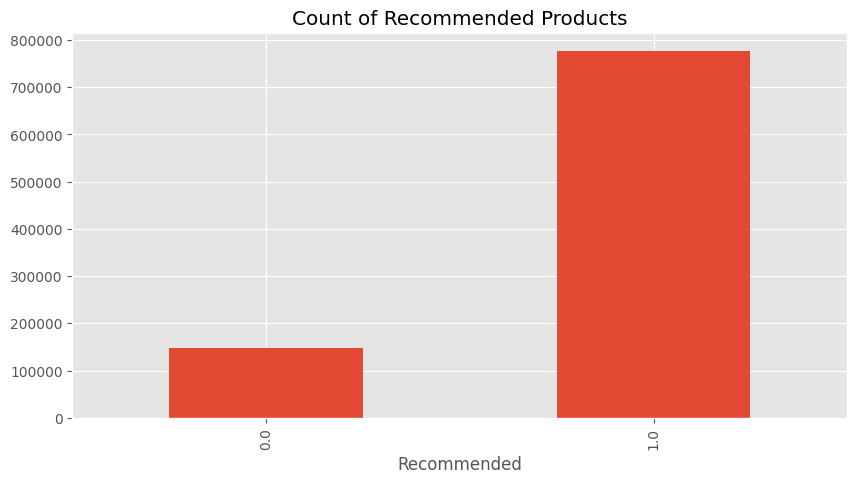

In [99]:
ax = df_essential['is_recommended'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Recommended Products',
          figsize=(10, 5))
ax.set_xlabel('Recommended')
plt.show()

A random review to be used as example

In [100]:
example = df_essential['review_text'][1337]
print(example)

Wow! Can’t go a night without putting this on! It’s incredible


Tokenization

In [101]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Wow', '!', 'Can', '’', 't', 'go', 'a', 'night', 'without', 'putting']

POS-Tagging

In [102]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Wow', 'IN'),
 ('!', '.'),
 ('Can', 'MD'),
 ('’', 'VB'),
 ('t', 'RB'),
 ('go', 'VB'),
 ('a', 'DT'),
 ('night', 'NN'),
 ('without', 'IN'),
 ('putting', 'VBG')]

Download `maxent_ne_chunker`

The `maxent_ne_chunker` contains two pre-trained English named entity chunkers trained on an ACE corpus

https://catalog.ldc.upenn.edu/LDC2005T09

In [103]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [104]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [105]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Wow/IN
  !/.
  Can/MD
  ’/VB
  t/RB
  go/VB
  a/DT
  night/NN
  without/IN
  putting/VBG
  this/DT
  on/IN
  !/.
  It/PRP
  ’/VBD
  s/RBR
  incredible/JJ)


### VADER Sentiment Scoring

#### Short Description

Vader (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing social media texts. Vader is a pre-trained sentiment analysis model that provides a sentiment score for a given text.

Vader uses a dictionary of words and rules to determine the sentiment of a piece of text. It uses a valence score for each word to determine its positivity or negativity. The valence score ranges from -4 to +4, with -4 being the most negative and +4 being the most positive.

Uses "bag of words" approach
- Stopwords are removed
- Each word is scored and combined into total score


Link: https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e#:~:text=Vader%20uses%20a%20dictionary%20of,4%20being%20the%20most%20positive.

#### Installing necessities

In [106]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [107]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

analyzer = SentimentIntensityAnalyzer()

#### Some simple examples

In [108]:
analyzer.polarity_scores('This is a very good product')

{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.4927}

In [109]:
analyzer.polarity_scores('This is the worst product ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [110]:
# Trying with the example from above
analyzer.polarity_scores(example)

{'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'compound': 0.658}

#### Polarity score on the DataFrame

In [114]:
df_essential.set_index('review_id', inplace=True)


In [115]:
res = {}

for i, row in tqdm(df_essential.iterrows()):
    text = row['review_text']
    rev_id = row['review_id']
    res[myid] = analyzer.polarity_scores(text)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html